In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import shutil
#import splitfolders
from PIL import Image
import torch
# import yaml
# from IPython.display import Image, clear_output
# from utils.plots import plot_results

c:\Users\Tobias\anaconda3\envs\dv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters and Constants


In [2]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 25

directory = "../datasets/exDark"
output = "../datasets/exDark/img_all"

## Download and Prepare the Dataset

In [3]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

In [4]:
if not os.path.exists('../exDark'):
    # !unzip -q "traffic-vehicles-object-detection.zip"
    print('Download Dataset')
else:
    print('Dataset already present')

Download Dataset


In [5]:
def rearangeDir(directory, output):
    for root, subdirectories, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))
            shutil.move(os.path.join(root, file), output)

In [6]:
#moves files from subdirectories into images/labels directory
def moveFiles(directory, old_dir):

    if not os.path.exists(directory + "/images"):
        os.mkdir(directory + "/images")
    if not os.path.exists(directory + "/labels"):
        os.mkdir(directory + "/labels")

    for filename in os.listdir(old_dir):
        source = os.path.join(old_dir, filename)
        if filename.endswith(".txt"):
            destination = os.path.join(directory + "/labels", filename)
            shutil.copyfile(source, destination)
        else:
            destination = os.path.join(directory + "/images", filename)
            shutil.copyfile(source, destination)

#moveFiles(directory, output)

In [7]:
#only for .txt files
def removeExtraChars(path, specialChar):
    for file in os.listdir(path):
        newname = file.split(specialChar, 1)[0] + ".txt"
        os.rename(os.path.join(path,file),os.path.join(path,newname))

#removeExtraChars("../datasets/exDark/labels", ".")

In [ ]:
# def removeExtraNulls(path, specialChar):
#     for file in os.listdir(path):
#                 label_lines = file.readlines()
#                 for label_line in label_lines:
#                     # label = label_line[0]
#                     bbox_string = label_line[0:]
#                     label, x_c, y_c, w, h, rest = bbox_string.split(' ', maxsplit=5)
#                     TODO


removes first line in text files

In [8]:
# path = "../datasets/exDark/labels/"
# for file in os.listdir(path):
#     with open(path + file, 'r') as fin:
#         data = fin.read().splitlines(True)
#     with open(path + file, 'w') as fout:
#         fout.writelines(data[1:])

In [9]:
# def splitfolders_(input_dir, output_dir):
#     splitfolders.ratio(input_dir, output=output_dir,
#         seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)


# splitfolders_("../datasets/exDark", "../datasets/exDark")

In [10]:
def resize(path, dirs):
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((416,416), Image.ANTIALIAS)
            imResize.save(f + e, quality=90)
            print("sucess")
        else:
            print("fail")

# path = directory + "/images/"
# dirs = os.listdir( path )
# resize(path, dirs)

### Create a Yaml File (copy in cell if needed)

%%writefile data.yaml

path: "../dataset/exDark" # Path relative to the `train.py` script. 
train: train/
val: val/ 
test: test/ 

Classes

nc: 12
names: [
    "Bicycle", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cup", "Dog", "Motorbike", "People", "Table"
] 

----------------------

### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Here is a function that converts it to `[x_min, y_min, x_max, y_max]` format.

In [12]:
class_names = [
    "Bicycle", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cup", "Dog", "Motorbike", "People", "Table"
] 

In [13]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        width = x2 - x1
        height = y2 - y1
        xmin = int(x1 + width/2)
        ymin = int(y1 + height/2)
        xmax = int(x2 + width/2)
        ymax = int(y2 + height/2)
        # width = xmax - xmin
        # height = ymax - ymin
        # print("xmin: " + str(xmin) + " box_num: " + str(box_num))
        # print("ymin: " + str(ymin) + " box_num: " + str(box_num))
        # print("xmax: " + str(xmax) + " box_num: " + str(box_num))
        # print("ymax: " + str(ymax) + " box_num: " + str(box_num))
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=4
        ) 
        cv2.putText(
            image, 
            labels[box_num],
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )
    return image

# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    plt.figure(figsize=(21, 12))
    for i in range(num_samples):
        image = cv2.imread(all_training_images[i+77])
        with open(all_training_labels[i+77], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                # label = label_line[0]
                bbox_string = label_line[0:]
                #print("Test: " + bbox_string)
                label, x_c, y_c, w, h, rest = bbox_string.split(' ', maxsplit=5)
                #print("Test: " + label, x_c, y_c, w, h)
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.show()

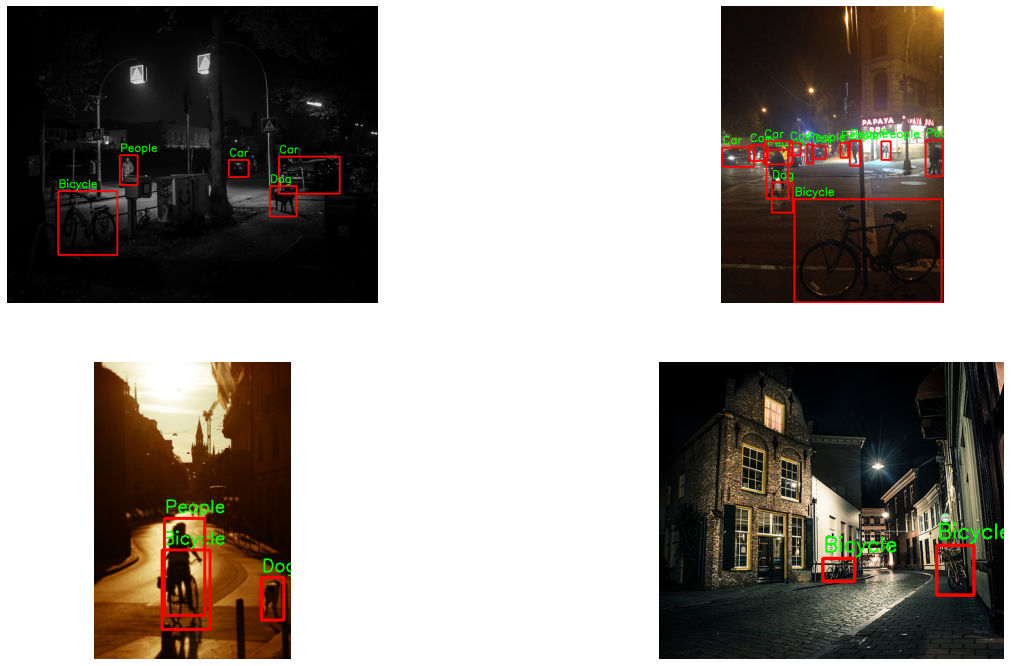

In [14]:
# Visualize a few training images.
# need to be in yolov5 directory
plot(
    image_paths='../datasets/exDark/train/images/*', 
    label_paths='../datasets/exDark/train/labels/*',
    num_samples=4,
)

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [15]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [16]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Training using YOLOV5

The next step is to train the neural network model.

### Train a Small (yolov5s) Model

Training all the layers of the small model.

In [17]:
monitor_tensorboard()

Reusing TensorBoard on port 6006 (pid 22160), started 1 day, 17:23:19 ago. (Use '!kill 22160' to kill it.)

In [19]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11263MB, multi_processor_count=28)


In [18]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --img 640 --data exDark.yaml --cfg yolov5s.yaml --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 5
results_6


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=exDark.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=results_6, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github:  YOLOv5 is out of date by 3 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
requirements: tensorboard>=2.4.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per C:\Ablage\Master\DeepVision\Studienarbeit\YOLOv5-vs-RCNN\yolov5\requirements.txt
requirements:  Restart runtime or rerun command for updates to ta

## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of images and videos.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [81]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !dir runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [74]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them. 

In [75]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

In [82]:
show_valid_results(RES_DIR)

[]


Parameterformat nicht ordnungsgem�� - "rain".
